<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Competitor Proximity Geospatial Analysis</b>
</header>

<hr></hr>
<p style = 'font-size:16px;font-family:Arial'><b>Quantifying the
Influence of Nearby Competitors on the Spending Behavior of a Retailer’s Customers</b></p>

<p style = 'font-size:16px;font-family:Arial'>A good deal of focus has been placed on the competitive
challenges that brick-and-mortar retailers face from online e-tailers. Having said
that, competition among brick-and-mortar stores is still an important part of
the retail competitive landscape. Unlike e-tailer competition, competition between physical stores depends in a fundamental way on the proximity among the competing retailer locations and the customers they
serve.</p>

<p style = 'font-size:16px;font-family:Arial'>Here, we perform an analysis that quantifies the effect of
proximity-to-competitors on the spending pattern of a retailer’s customers. The results can be used to guide proximity-based marketing tactics in which consumers are targeted with advertising and promotional
content based on their location.</p>

<p style = 'font-size:16px;font-family:Arial'>We take the perspective of a brick-and-mortar retailer with
the following information available:</p>

<ul style = 'font-size:16px;font-family:Arial'>
<li>Their store locations.</li>

<li>A record of customers who have shopped at their stores, the amounts they have spent and where they came from (as defined by a home or place-of-business address.)</li>

<li>The locations of their competitor stores.</li>
    
</ul>

<p style = 'font-size:16px;font-family:Arial'>While we cannot know how much, if anything, customers
of the retailer are spending at competitors, it is reasonable to assume that those who are nearby to a competitor have, at least, the potential to shop there. When that happens, there is a loss of revenue that otherwise might have gone to a store of mine.</p>

<p style = 'font-size:16px;font-family:Arial'>The question is, </p>

<p style = 'font-size:16px;font-family:Arial'><i><b>Even in the absence of direct information about whether my
customers are shopping at competitors and how much they spend there, is there a way to detect and quantify the
    presence of that split-spend phenomenon within my customer population?</b></i></p>

<p style = 'font-size:16px;font-family:Arial'>We’ll say a customer of the retailer has a nearby competitor
if they are within a certain distance/drivetime of a competitor location. In essence, this involves defining a
trade-area for each competitor location. We designate a customer as having a nearby competitor if they are within one (or more) of those competitor trade areas.</p>

<p style = 'font-size:16px;font-family:Arial'>That is a spatially-oriented segmentation exercise that
divides the customers into two
sub-populations, those with a nearby competitor and those without. Once those segments are computed, a straightforward statistical comparison of the mean spend of those two populations can be performed.In particular, we’re looking to see if the mean spend of my customers with a nearby competitor is less than
the mean spend of those without a nearby competitor. If so, it seems reasonable to conclude those
customers with a nearby competitor (on whole) are splitting their spend. In that case, the results of the analysis provide the basis for targeting those customers with marketing and promotional
material with the goal of winning more of that split-spend.</p>

<p style = 'font-size:16px;font-family:Arial'>This demo employs the geospatial extensions of Vantage to assess the effect that the presence of nearby competitors may have on the spending pattern of a brick-and-mortar retailer's existing customers. We can store spatial data in Vantage and can compute it with other enterprise business data. In a sense, the mantra for the value of geospatial advantage is the same as our other analytics apply the analytic where the data lives to fully exploit the performance and scalability of our platform.</p>
<b style = 'font-size:18px;font-family:Arial'>Using the teradataml Python library</b>
<p style = 'font-size:16px;font-family:Arial'>This notebook makes use of Teradata's teradataml library which provides a convenient Python language interface for working with data that resides on a Vantage system.  The interface is based on a pandas-like virtual dataframe and a set of wrapper functions that delegate data manipulation and analytic work to Vantage. In this way, data movement and the limitations of client-side memory/compute resources are avoided and the performance and scalability of the Vantage platform is leveraged fully.</p>


<hr>
<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Import python packages, connect to Vantage and explore the dataset</h1>

<p style = 'font-size:16px;font-family:Arial'>Let's start by importing the libraries needed.</p>

In [ ]:
#import libraries
import geopandas as gpd
import matplotlib.pyplot as plt 
import pandas as pd
import getpass
from teradataml.dataframe.dataframe import DataFrame
from teradataml.dataframe.dataframe import in_schema
from teradataml.context.context import create_context, remove_context, get_context
from teradataml.geospatial.geodataframe import GeoDataFrame

import plotly.express as px
import plotly.graph_objects as go
import json
from pandas import json_normalize
from  ipywidgets import widgets, interact
from shapely import wkt

display.max_rows = 5 

import pandas as pd
import io
import geopandas as gpd
import shapely.geometry
import plotly.express as px
from shapely import wkt

<p style = 'font-size:16px;font-family:Arial'>You will be prompted to provide the password. Enter your password, press the Enter key, then <b>use down arrow</b> to go to next cell.</p>

In [ ]:
%run -i ../startup.ipynb
eng = create_context(host = 'host.docker.internal', username='demo_user', password = password)
eng.execute("SET query_band='DEMO=competitor_proximity_geospatial_analysis.ipynb;' UPDATE FOR SESSION;")

<h2 style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Getting Data for This Demo</h2>
<p style = 'font-size:16px;font-family:Arial'>We have provided data for this demo on cloud storage. You have the option of either running the demo using foreign tables to access the data without using any storage on your environment or downloading the data to local storage which may yield somewhat faster execution, but there could be considerations of available storage. There are two statements in the following cell, and one is commented out. You may switch which mode you choose by changing the comment string.</p>

In [ ]:
%run -i ../run_procedure.py "call get_data('DEMO_Market_cloud');"
 # takes about 30 seconds, estimated space: 0 MB
#%run -i ../run_procedure.py "call get_data('DEMO_Market_local');" 
# takes about 30 seconds, estimated space: 3 MB

<p style = 'font-size:16px;font-family:Arial'>Next is an optional step – if you want to see status of databases/tables created and space used.</p>

In [ ]:
%run -i ../run_procedure.py "call space_report();"

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Initial Data Sets</h1>
<p style = 'font-size:16px;font-family:Arial'>Let's start by exploring the datasets we have. We have four tables with geogaphical information Store which has the my store location, Competitor which has by competitor's store location, Customer which has my customer location and Competitor_dtpoly which is the drivetime polygon for customer. A drive time Polygon is the area that is accessible from a starting point within a specified time threshold. The drive time Polygon takes into account the fact that the travel is happening over the existing network of roads, with trade areas defined, we perform the segmentation by computing the customers which are within any of the trade areas.

In [ ]:
# Get a Teradata (Geo)DataFrame - this creates a local reference to the corresponding table on Vantage.
# A GeoDataFrame is required since the store, customer, competitor and competitor_dtpoly tables each 
# contain an ST_Geometry-typed column.

tgdf_store      = GeoDataFrame(in_schema("DEMO_Market", "Store"))

In [ ]:
tgdf_customer   = GeoDataFrame(in_schema("DEMO_Market", "Customer"))
tgdf_competitor = GeoDataFrame(in_schema("DEMO_Market", "Competitor"))
tgdf_dtpoly     = GeoDataFrame(in_schema("DEMO_Market", "Competitor_dtpoly"))

In [ ]:
# Show underlying query associated with (Geo)Dataframe

tgdf_store.show_query()

In [ ]:
# Shape will give us the record and column count of the (Geo)Dataframe
tgdf_store.shape

In [ ]:
tgdf_store

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Store Locations</h1>

<p style = 'font-size:16px;font-family:Arial'> Let us visualize the store location data for better understanding. All the calculations needed are done in Vantage and we are using python libraries for visulatization only.

In [ ]:
#pandas df for plotting store locations
df_store=tgdf_store.x.y.to_pandas(all_rows= True).reset_index()
df_store = df_store.rename(columns={'x_ptLoc_geom': 'lon','y_ptLoc_geom': 'lat'})
df_store

In [ ]:
fig1 = px.scatter_mapbox(df_store, title='My Store Locations',lat="lat", lon="lon", hover_name="id", 
                        hover_data=["id"],
                        color_discrete_sequence=["blue"], zoom=8, height=300)
fig1.update_layout(mapbox_style="open-street-map", title_x=0.5,
    title_y=0.98,)
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig1.show()

<p style = 'font-size:16px;font-family:Arial'>The map above displays my store locations. We have 10 stores for our demo.

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Competitor Store Location</h1>

<p style = 'font-size:16px;font-family:Arial'> Similarly we can plot the comperitor store locations.

In [ ]:
#pandas df for plotting store locations
df_competitor=tgdf_competitor.x.y.to_pandas(all_rows= True).reset_index()
df_competitor = df_competitor.rename(columns={'x_ptLoc_geom': 'lon','y_ptLoc_geom': 'lat'})
df_competitor

In [ ]:
fig2 = px.scatter_mapbox(df_competitor, title='Competitor Store Locations',lat="lat", lon="lon", hover_name="id", 
                        hover_data=["id"],
                        color_discrete_sequence=["red"], zoom=8, height=300)
fig2.update_layout(mapbox_style="open-street-map", title_x=0.5,
    title_y=0.98,)
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

<p style = 'font-size:16px;font-family:Arial'>The map above shows competitor store locations. We have 7 competitor stores in our demo.

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Customer Location</h1>

In [ ]:
#pandas df for plotting store locations
df_customer=tgdf_customer.x.y.to_pandas(all_rows= True).reset_index()
df_customer = df_customer.rename(columns={'x_ptLoc_geom': 'lon','y_ptLoc_geom': 'lat'})
df_customer

In [ ]:
fig3 = px.scatter_mapbox(df_customer, title='Customers',lat="lat", lon="lon", hover_name="id", 
                        hover_data=["id"],
                        color_discrete_sequence=["black"],zoom=8, height=300)
fig3.update_layout(mapbox_style="open-street-map", title_x=0.5,
    title_y=0.98,)
fig3.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig3.show()

<p style = 'font-size:16px;font-family:Arial'>The map above shows the location of customers. We have around 300 customers in our demo.

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Drivetime Polygons</h1>


<p style = 'font-size:16px;font-family:Arial'> As stated before a drive time polygon is the area that is accessible from a starting point within a specified time threshold. We have used threshold of 5min and 10min in out demo.

In [ ]:
tgdf_dtpoly.tdtypes

In [ ]:
tgdf_dtpoly.dtypes

In [ ]:
#tdml df to pandas df for drivetime of 5min
df_dtpoly_5=tgdf_dtpoly[(tgdf_dtpoly.drivetime == 5)].to_pandas(all_rows= True).reset_index()

In [ ]:
df_dtpoly_5

In [ ]:
df_dtpoly_5.dtypes

In [ ]:
df_dtpoly_5['drivetime'] = df_dtpoly_5['drivetime'].apply(str)
fig4 = px.choropleth_mapbox(
       geojson=gpd.GeoSeries(df_dtpoly_5["dtPoly"].apply(wkt.loads)).__geo_interface__,
       locations=df_dtpoly_5.index, opacity =0.4,
       color=df_dtpoly_5["drivetime"],
       color_discrete_sequence=["red", "blue"],
       title = "Customer drivetime polygons of 5min",zoom=8, height=300)
fig4.update_layout(mapbox_style="open-street-map", title_x=0.5,
    title_y=0.98,mapbox_center = {"lon": -84, "lat": 34},)
fig4.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig4.show()

<p style = 'font-size:16px;font-family:Arial'>The above map shows the drivetime polygons of 5min from the competitor store. The customers within these polygons most likely to share their spend with the competitor stores.

In [ ]:
df_dtpoly_10=tgdf_dtpoly[(tgdf_dtpoly.drivetime == 10)].to_pandas(all_rows= True).reset_index()
df_dtpoly_10['drivetime'] = df_dtpoly_10['drivetime'].apply(str)
fig5 = px.choropleth_mapbox(
       geojson=gpd.GeoSeries(df_dtpoly_10["dtPoly"].apply(wkt.loads)).__geo_interface__,
       locations=df_dtpoly_10.index, opacity =0.4,
       color=df_dtpoly_10["drivetime"],
       color_discrete_sequence=["blue" , "red"],
       title = "Customer drivetime polygons of 10min",zoom=8, height=300)
fig5.update_layout(mapbox_style="open-street-map", title_x=0.5,
    title_y=0.98,mapbox_center = {"lon": -84, "lat": 34},)
fig5.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig5.show()

<p style = 'font-size:16px;font-family:Arial'>The above map shows the drivetime polygons of 10min from the competitor store. 

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Combining all of the maps together</h1>


<p style = 'font-size:16px;font-family:Arial'>We have seen all the maps individually now lets take a look at them in a single map for better understanding.

In [ ]:
# Create checkbox widgets for each figure
checkbox_fig1 = widgets.Checkbox(value=True, description="My Stores(Blue Marker)")
checkbox_fig2 = widgets.Checkbox(value=True, description="Competitor Stores(Red Marker)")
checkbox_fig3 = widgets.Checkbox(value=True, description="Customers(Black Marker)")
checkbox_fig4 = widgets.Checkbox(value=True, description="Drivetime Polygon of 5min")
checkbox_fig5 = widgets.Checkbox(value=True, description="Drivetime Polygon of 10min")

# Function to update the displayed figures based on checkbox options
def update_displayed_figures(change=None):
   
    # Create a new combined figure based on the selected checkboxes
    combined_fig = go.Figure()
    
    if checkbox_fig1.value:
        for trace in fig1.data:
            combined_fig.add_trace(trace)
    if checkbox_fig2.value:
        for trace in fig2.data:
            combined_fig.add_trace(trace)
    if checkbox_fig3.value:
        for trace in fig3.data:
            combined_fig.add_trace(trace)
    if checkbox_fig4.value:
        for trace in fig4.data:
            combined_fig.add_trace(trace)
    if checkbox_fig5.value:
        for trace in fig5.data:
            combined_fig.add_trace(trace)        

    combined_fig.update_layout(height= 800,mapbox_style="open-street-map",title = "Competitor Proximity Analysis",
                               title_x=0.1,title_y=0.98,
                               title_font=dict(color='black', size=24),
                               mapbox_center = {"lon": -84.35, "lat": 34}, mapbox_zoom = 9, 
                               )
    combined_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    # Display the combined figure
    with output:
        output.clear_output(wait=True)
        display(combined_fig)

# Attach the function to the checkboxes' change events
checkbox_fig1.observe(update_displayed_figures)
checkbox_fig2.observe(update_displayed_figures)
checkbox_fig3.observe(update_displayed_figures)
checkbox_fig4.observe(update_displayed_figures)
checkbox_fig5.observe(update_displayed_figures)

# Display the checkboxes and the initial combined figure
output = widgets.Output()

# Arrange the layout to display checkboxes above the combined figure
checkboxes_container = widgets.VBox([checkbox_fig1, checkbox_fig2, checkbox_fig3, checkbox_fig4,checkbox_fig5])
display(checkboxes_container, output)

# Display the initial combined figure
update_displayed_figures()


<p style = 'font-size:16px;font-family:Arial'>We can check/uncheck the underlaying data for the map above depending upon the our analysis.

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Profiling Analysis</h1>
<h2 style = 'font-size:18px;font-family:Arial'>Customer Spend</h2>
<p style = 'font-size:16px;font-family:Arial'>Perform some simple profiling of the spend data for the poplulation of customers as a whole using Teradata's Vantage Analytic Library (VAL).</p>
</hr>

In [ ]:
from teradataml import *
from teradataml.analytics.valib import *

# Point teradataml to the install database of the VAL library
from teradataml import configure
configure.val_install_location = "val"

from teradataml import valib

In [ ]:
# Profile the spend data of customers

obj = valib.Explore(data=tgdf_customer, columns='spend')
 
# Print the frequency results.
print(obj.frequency_output)
 
# Print the histogram results.
print(obj.histogram_output)
 
# Print the statistics results.
print(obj.statistics_output)
 
# Print the values results.
print(obj.values_output)

In [ ]:
# Show query associated with calling into VAL

obj.show_query()

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy import func

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#define histogram function

def plot_distribution(inp):
    plt.figure()
    ax = sns.distplot(inp,bins=10)
    plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() / 10,
        max_ - max_ / 10,
        "Mean: {:.2f}".format(inp.mean()),
    )
    return plt.figure

In [ ]:
# Plot empirical distribution of spend for entire customer population

plot_distribution(tgdf_customer.to_pandas().spend)

<h2 style = 'font-size:18px;font-family:Arial'>Spatial divison of customers</h2>
<p style = 'font-size:16px;font-family:Arial'>Perform the spatial computation that divides the customer population into 2 sub-populations; those with a nearby competitor and those without.<br>
Determine which customers have a nearby competitor (5 min.) 

In [ ]:
#Determine which customers have a nearby competitor (5 min.) 

tgdf_dtpoly5 = tgdf_dtpoly[(tgdf_dtpoly.drivetime==5)]

In [ ]:
# Join customer dataframe with dtpoly5 dataframe

cust_dtpoly5_join = tgdf_customer.join(tgdf_dtpoly5, how="cross", lsuffix="l", rsuffix="r")

In [ ]:
# show the corresponding query for the joined customer df  and 5min drivetime polygon df

cust_dtpoly5_join.show_query()

In [ ]:
cust_dtpoly5_join.dtypes

In [ ]:
# Build 2 segments: those with a competitor nearby (5min) and those without

nearby5_cust    = cust_dtpoly5_join[(cust_dtpoly5_join.ptLoc.intersects(cust_dtpoly5_join.dtPoly) == 1)]

no_nearby5_cust = cust_dtpoly5_join[(cust_dtpoly5_join.ptLoc.intersects(cust_dtpoly5_join.dtPoly) == 0)]

In [ ]:
nearby5_cust.show_query()

In [ ]:
nearby5_cust.shape

In [ ]:
df_nearby5 = nearby5_cust.to_pandas()
df_nearby5.head(5)

In [ ]:
# Histogram of spend for customer sub-population with nearby competitor.

plot_distribution(df_nearby5.spend)

In [ ]:
df_no_nearby5 = no_nearby5_cust.to_pandas()
# Histogram of spend for customer sub-population without nearby competitor.

plot_distribution(df_no_nearby5.spend)

In [ ]:
# Overlayed histograms of spend for customer sub-populations with/without nearby competitor

plt.figure()
ax1 = sns.distplot(df_nearby5.spend)
ax2 = sns.distplot(df_no_nearby5.spend)
plt.axvline(np.mean(df_nearby5.spend), color='b', linestyle='dashed', linewidth=5)
plt.axvline(np.mean(df_no_nearby5.spend), color='orange', linestyle='dashed', linewidth=5)

<h2 style = 'font-size:18px;font-family:Arial'>Statistical comparison of the mean spend</h2>
<p style = 'font-size:16px;font-family:Arial'>Perform a statistical comparison of the mean spend for the 2 customers sub-populations; those with a nearby competitor and those without.</p>


<p style = 'font-size:16px;font-family:Arial'>We use VAL's parametric test functionality to perform a <i>Two-Sample T-Test for equality of the population means</i> (using <i>unpaired</i> observations from the two populations.) The comparison is couched in the form of a Hypothesis test designed to determine whether the data supports the null hypothesis (H<sub>0</sub>) that the two population means (&#956;<sub>no_nearby</sub> and &#956;<sub>nearby</sub>) are equal.  That is,</p> 
    
<p style="text-align:center">H<sub>0</sub>:  &#956;<sub>no_nearby</sub> - &#956;<sub>nearby</sub> = 0</p>
    
<p style = 'font-size:16px;font-family:Arial'>The null hypothesis is setup as the claim we would like to reject. The alternative hypothesis (H<sub>A</sub>) is the claim supported by rejecting the null hypothesis. In this case, that could be that the two population means are simply unequal (two-tailed test) or, more particularly, that the mean spend of customers without a nearby competitor is strictly greater than the mean spend of those with a nearby comptetitor (one-tailed test.)  Here, the one-tailed test is more appropriate since we're looking for a particular direction in the relationship between the means of the two populations. That is,</p>
    
<p style="text-align:center">H<sub>A</sub>:  &#956;<sub>no_nearby</sub> - &#956;<sub>nearby</sub> > 0</p>

<p style = 'font-size:16px;font-family:Arial'>The significance level of a hypothesis test, α, is the pre-chosen probability that we reject the null hypothesis (in favor of the alternative) when the null hypothesis is actually true. It is also called the Type I error rate.</p> 
    
<p style="text-align:center">α = Level of significance = P(Type I error) = P(Reject H<sub>0</sub> | H<sub>0</sub> is true)</p> 

<p style = 'font-size:16px;font-family:Arial'>1-α is called the Power of the test and is the probability of accepting the null hypothesis when it is true. That is,</p>
    
<p style="text-align:center">1-α = Power = P(Accept H<sub>0</sub> | H<sub>0</sub> is true)</p>
    
<p style = 'font-size:16px;font-family:Arial'>The choice of the significance level α at which you reject H<sub>0</sub> is arbitrary.  Typically, .05 (less than 1 in 20 chance of being wrong), .01 and .001 levels are used. In other words, when we reject H<sub>0</sub>, we want to be confident it is because the alternative holds (even at the expense, to some degree, of failing to reject H<sub>0</sub> when the alternative holds.)</p>
    
<p style = 'font-size:16px;font-family:Arial'>If there is no difference in the population means, then we expect outcomes of our test statistic to range between the percentile points t<sub>1</sub> and t<sub>2</sub> on a T distribution (with the appropriate degrees of freedom) corresponding to<p>
    
<p style="text-align:center">P(T<= t<sub>1</sub>) = α/2</p>

<p style = 'font-size:16px;font-family:Arial'>and</p>
    
<p style="text-align:center">P(T<=t<sub>2</sub>) = 1-α/2</p> 
    
<p style = 'font-size:16px;font-family:Arial'>respectively. Since we are using a one-tailed test, we can allocate the entire α level to the right tail of the the distribution of our test statistic T to account for the fact that we are really only interested in rejecting a null hypothesis corresponding to</p>

<p style="text-align:center">H<sub>0</sub>:  &#956;<sub>no_nearby</sub> - &#956;<sub>nearby</sub> &ge; 0</p>
    
<p style = 'font-size:16px;font-family:Arial'>The P-value in a test of hypothesis is a computed/looked-up probability (from a T-distribution in this case) that represents the likelihood of seeing outcomes of our test statistic that are more extreme than the value that was actually observed (when H<sub>0</sub> holds) . More precisely, the P-value is defined as the probability of our test-statistic, in general, taking on a value greater than the particular observed value of the test stastic.  That is,</p>
    
<p style="text-align:center">P-value = P(T > t)</p>
    
<p style = 'font-size:16px;font-family:Arial'>where t is the computed value of our test-statistic and T is a student-T random variable (with the appropriate degrees of freedom.)</p>
    
<p style = 'font-size:16px;font-family:Arial'>When</p>
    
<p style="text-align:center">P-Value < α</p>
               
<p style = 'font-size:16px;font-family:Arial'>then our observed outcome does not look like an extreme outcome under H<sub>0</sub> relative to our choice for α so we fail to reject H<sub>0</sub>.   A P-value that exceeds α is an indication that the value of our test statistic appears too extreme under H<sub>0</sub> so we reject the null Hypothesis (with confidence that the likelihood of doing so incorrectly is controlled by our choice of α.)</p>

In [ ]:
# Perform Parametric test of comparison of population means

obj = valib.ParametricTest(data=tgdf_customer,
                           first_column="spend",
                           paired=False,
                           second_column="nearby5",
                           equal_variance=False,
                           stats_database="val")
 
# Print the results.
print(obj.result)

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Interpretation and Inference</h1>

<p style = 'font-size:16px;font-family:Arial'>The default significance level for the test is α = 0.05.  The observed value of our test statistic is 10.4809 which has a corresponding P-Value of 0.  In other words, there is (effectively) zero probability of observing a test statistic value greater than 10.4809 when the null hypothesis of equal population means holds.  Since our P-Value (0) is less than α (.05), we reject the null hypothesis that the two population means are equal and infer the data supports the alternative that customers with no nearby competitor have a mean spend greater than the mean spend of customers with a nearby competitor.</p>

<p style = 'font-size:16px;font-family:Arial'>Having detected a difference in the two populations is strong justification for employing a location-based marketing campaign that targets customers with a nearby competitor with advertising material and/or promotional offers devised to influence the split spend behavior in that population of customers.</p>

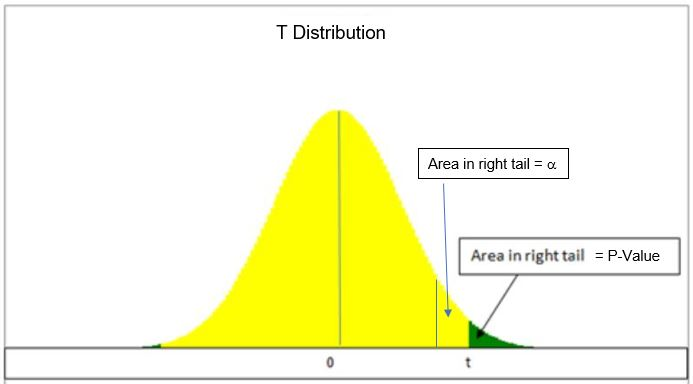

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Cleanup</h1>

<p style = 'font-size:16px;font-family:Arial'>The following code will clean up tables and databases created above.</p>

In [ ]:
%run -i ../run_procedure.py "call remove_data('DEMO_Market');" 
#Takes 10 seconds

In [ ]:
# Disconnect from Vantage
remove_context()

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Reference Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial'> 
<li>Teradata® Geospatial Utilities User Guide: <a href = 'https://docs.teradata.com/r/Teradata-Geospatial-Utilities-User-Guide/June-2022/Teradata-Geospatial-Utilities-Overview/Welcome-to-Teradata-Tools-and-Utilities-Teradata-Geospatial-Utilities-User-Guide'>https://docs.teradata.com/r/Teradata-Geospatial-Utilities-User-Guide/June-2022/Teradata-Geospatial-Utilities-Overview/Welcome-to-Teradata-Tools-and-Utilities-Teradata-Geospatial-Utilities-User-Guide</a></li>
    
</ul>

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2023 Teradata. All Rights Reserved</footer>